# Exploring mental health - Binary Classification with fastai and Deployment with BentoML.

I use data from a mental health survey to explore factors that may cause individuals to experience depression and use this to classify whether an individual is at risk of depression or not.

The data used for this was synthetically generated from the Depression Survey/Dataset which you can find [here](https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis). The original dataset was collected from a survey carried out among adults aimed at understanding depression risk factors based on inputs provided by particpants in the survey.

> Quoting the dataset description, This dataset was collected as part of a comprehensive survey aimed at understanding the factors contributing
> to depression risk among adults. It was collected during an anonymous survey conducted between January and June 2023. The survey was conducted
> across various cities, targeting individuals from diverse backgrounds and professions. Participants, ranging from 18 to 60 years old, 
> voluntarily provided inputs on factors such as age, gender, city, degree, job satisfaction, study satisfaction, study/work hours, and family 
> history among others. Participants were asked to provide inputs without requiring any professional mental health assessments or diagnostic 
> test scores.

The target variable is either "0" or "1" hence our goal here will be to predict the target class which represent "Yes" and "1".

Exploring this dataset can help us understand and provide key insights into how everyday factors contribute to our mental health. I originally built this as a solution to the exploring mental health data kaggle competition. You can find the solution link [here](https://www.kaggle.com/code/rubanzasilva/eda-gradient-boosting-neural-nets-s04e11).

My goal for this was to deploy the model I built for the above competition. To do this, I serve the model with bentoml, then deploy the model to a cloud provider (bento cloud). This gives me an API that can be used when building our user interface for end-user interaction or integrating our predictions into existing solutions.

## Library Imports
We start by importing the libraries we shall need to build the solution. To install the neccesary libraries before hand. Run **pip install requirements.txt** via your terminal while in this project directory. This will automatically install the dependencies defined in the requirements.txt file.

In [ ]:
#| code-fold: show

import numpy as np
from numpy import random
#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
#import matplotlib.pyplot as plt
#from fastai.imports import *
#np.set_printoptions(linewidth=130)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pathlib import Path
import os
import xgboost as xgb
#from xgboost import plot_importance
from xgboost import XGBClassifier
import warnings
import gc
import pickle
from joblib import dump, load
import typing as t
import bentoml
from bentoml.validators import DataframeSchema

torch.manual_seed(42)

## Define data path / location

In [2]:
#| code-fold: show

path = Path('data/')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')

## Data Preprocessing

Below I prepare my data for machine learning using the below fastai functions. Once my data is in a suitable format for machine learning training, we pass it to an XGBoost model which is a popular gradient boosting based framework that works quite efficiently for tabular data.

First, we define categorical and continuous variables, I use the fastai [cont_cat_split](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continuous variables based on the cardinality of my column values.

This takes an argument max card whose default is 20. If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continuous, and vice versa.

In [3]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')

### Split into training and validation set 
The [RandomSplitter](https://docs.fast.ai/data.transforms.html#randomsplitter) below separates the training set into a training and validation set based on the value of the argument valid_pct.

In [4]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

### TabularPandas
Below we define a [TabularPandas](https://docs.fast.ai/tabular.core.html#tabularpandas) object.
Here we declare the continuous and categorical columns, the dataset splitting strategy, the preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting, and the type of problem we are optimizing for such as binary classification in this case.



In [5]:
#| code-fold: show
#| output: false

to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Depression',
                   y_block=CategoryBlock(),
                   splits=splits)

/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

### DataLoaders
We define a dataloaders which prepares our data for input into our neural network.Here we can define our batch size.

In [6]:
#| code-fold: show
#| output: false

dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

### Fastai intergation with other libraries

To quote the fastai documentation
> Integration with libraries such as Random Forests and XGBoost requires only one extra step, that the .dataloaders call did for us. Let’s look
> at our to again. Its values are stored in a DataFrame like object, where we can extract the cats, conts, xs and ys if we want to:

In [7]:
to.xs[:3]

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness,...,Job Satisfaction_na,Financial Stress_na,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
id,,,,,,,,,,,,,,,,,,,,,
129184,120,2,59,2,15,16,16,20,1,2,...,1,1,1.422830,-0.04561,1.591172,0.033461,0.01841,-1.561847,-0.842910,0.714559
45392,184,2,87,2,4,30,16,90,2,2,...,1,1,0.777218,-0.04561,-0.794526,0.033461,0.01841,-1.561847,-0.065067,0.714559
40955,218,1,38,2,56,28,21,76,1,2,...,1,1,0.373710,-0.04561,0.795939,0.033461,0.01841,-0.772831,0.194214,-1.406225


> Now that everything is encoded, you can then send this off to XGBoost or Random Forests by extracting the train and validation sets and their
> values:

In [8]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

## Train and save a model

We can now use the above directly with our XGBoost library. The below code calls trains a XGBoost Classifier model.

In [9]:
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

#xgb_preds = tensor(xgb_model.predict(test_dl.xs))
#xgb_preds_x = tensor(xgb_model.predict(X_test))
#accuracy = accuracy_score(y_test, xgb_preds_x)
#print(f"Model accuracy: {accuracy}")

After training, we use the **bentoml.xgboost.save_model** API to save the model to the bentoml model store. This is a local storage that bentoml has to store and manage models etc. This models can be accessed later by calling them and they can be used to make new predictions.

In [10]:
bentoml.xgboost.save_model("mental_health_v1", xgb_model)

Model(tag="mental_health_v1:qud2aig33o5qbjo7", path="/home/rubanza/bentoml/models/mental_health_v1/qud2aig33o5qbjo7/")

We can check for our model by running the below code.

In [ ]:
!bentoml models list
#if running via terminal, use bentoml model list directly.

 Tag                           Module           Size        Creation Time       
 mental_health_v1:qud2aig33o…  bentoml.xgboost  432.87 KiB  2025-01-26 14:48:54 
 mental_health_v1:2plmd4g32c…  bentoml.xgboost  421.24 KiB  2025-01-26 13:32:22 
 mental_health_v1:axqqhmg3z6…  bentoml.xgboost  421.24 KiB  2025-01-26 13:19:27 
 mental_health_v1:iz77zng3ec…  bentoml.xgboost  421.24 KiB  2025-01-25 16:28:34 
 mental_health_v1:4qpareg3d6…  bentoml.xgboost  421.24 KiB  2025-01-25 16:25:48 
 sticker_sales_v1:lhotw4gyr6…  bentoml.xgboost  476.22 KiB  2025-01-22 10:06:07 
 mental_health_v1:exbjk3wm4k…  bentoml.xgboost  421.24 KiB  2025-01-07 13:28:34 


### Test the model

The previous cell outputs the models we have saved

| Tag | Module | Size | Creation Time |
|-----|--------|------|---------------|
| mental_health_v1:qud2aig33o… | bentoml.xgboost | 432.87 KiB | 2025-01-26 14:48:54 |

Our next mode is to test the model we have just saved. This ensures that the model we saved runs as expected. 
We start by loading our saved model mental_health_v1:qud2aig33o5qbjo7.

In [13]:
# Load the model by setting the model tag
booster = bentoml.xgboost.load_model("mental_health_v1:qud2aig33o5qbjo7")

In [14]:
#| code-fold: show

# Uncomment cells if running this test case in a separate file
#path = Path('data/')
#test_df = pd.read_csv(path/'test.csv',index_col='id')
#train_df = pd.read_csv(path/'train.csv',index_col='id')
#cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
#to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   #cat_names = cat_names,
                   #cont_names = cont_names,
                   #y_names='Depression',
                   #y_block=CategoryBlock(),
                   #splits=splits)
#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

res = tensor(booster.predict(test_dl.xs))
print(res)

tensor([0, 0, 0,  ..., 0, 1, 0])


Expected results 

*tensor([0, 0, 0,  ..., 0, 1, 0])*

## Create a BentoML service

First, we use a **@bentoml.service** to define a bentoml service and also define additional configurations like reosurce allocation and timeout.

I load our model from the model store and define it as a class variable. I then create a function **preprocess** to take in our input data and pass it through the same steps we did when training and testing our model.

from here, we can use the **@bentoml.api** to expose our predict functions as API endpoints. This defines what our model input is for example below our predict function expects data in the form of a pandas data frame while our predict_csv function expects a CSV file as the name would suggest.

Furthermore, I also define the expected output type which is a numpy array for the below cases. I then pass our data through the preprocessing function defined previously and finally return the new predictions on the test data.

In [16]:
#| code-fold: show

@bentoml.service(
    resources={"cpu": "8"},
    traffic={"timeout": 10},
)

class MentalHealthClassifier:
    #retrieve the latest version of the model from the BentoML model store
    bento_model = bentoml.models.get("mental_health_v1:latest")
    #bento_model = BentoModel('mental_health_v1:q5kcqtf5ys3qoaav')


    def __init__(self):
        self.model = bentoml.xgboost.load_model(self.bento_model)

    def preprocess(self, data):
        path = Path('data/')
        train_df = pd.read_csv(path/'train.csv',index_col='id')
        test_df = pd.read_csv(path/'test.csv',index_col='id')
        cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                           cat_names = cat_names,
                           cont_names = cont_names,
                           y_names='Depression',
                           y_block=CategoryBlock(),
                           splits=splits)
        dls = to.dataloaders(bs=64)
        test_dl = dls.test_dl(data)
        test_df_new = test_dl.xs
        return test_df_new
  

    @bentoml.api
    def predict(self, data:pd.DataFrame) -> np.ndarray:
        data = self.preprocess(data)
        prediction = self.model.predict(data)
        #prediction = torch.tensor(prediction)
        return prediction
 
    
    @bentoml.api()
    def predict_csv(self,csv:Path) -> np.ndarray:
        csv_data = pd.read_csv(csv)
        csv_data = self.preprocess(csv_data)
        prediction_csv = self.model.predict(csv_data)
        return prediction_csv

`bentoml.models.get()` as the class attribute is not recommended because it requires the model to exist at import time. Use `bento_model = BentoModel('mental_health_v1:qud2aig33o5qbjo7')` instead.


We then run this by running **bentoml serve service:MentalHealthClassifier** in our project directory which starts our service.

The server is now active via http://localhost:3000/ as shown below. You can interact with it using swagger UI, CURL or with a python client.

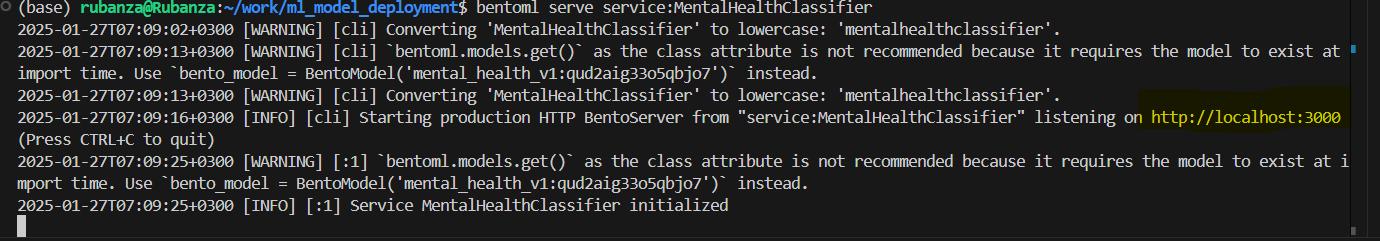

## Deploy to a cloud provider (BentoCloud)

We push our service to a cloud provider so anyone can interact with our API. In this case, we use bentocloud a cloud service from bentoml since it has a one click deployment integration.

BentoML provides a standard format for packaging AI/ML services called a Bento. This contains our source code, dependencies, model artifacts, and configurations. This helps ensure reproducibility across different environments.

I create a YAML file called **bentofile.yaml**. Here we specify our configuration options for building a BentoML project into a Bento. Let us define define one below. To see all the available options/fields for our Bento Build, check out [Bento build Options](https://docs.bentoml.com/en/latest/reference/bentoml/bento-build-options.html).

Below is the source code that goes into our bentofile.yaml

```
service: "service:MentalHealthClassifier"
labels:
  owner: "rubanza"
  stage: "production"
include:
  - "*.py"
  - "data/"
python:
  packages:
    - bentoml>=1.3.18
    - xgboost
    - scikit-learn==1.3.1
    - pandas
    - numpy
    - fastai
```

To get started, Create a Bento Cloud account if you haven't already and then login via the terminal while in your project directory by running **bentoml cloud login**. Paste in your exisiting API token, or create a new one if needed.

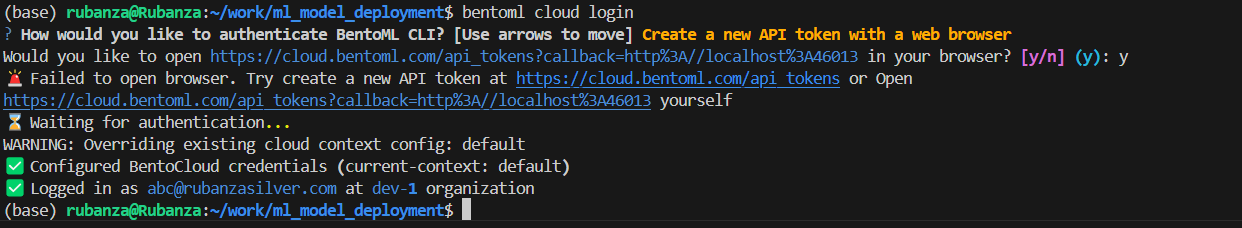

In [ ]:
#run the below command via the terminal in your project directory
#bentoml cloud login 

We can now deploy our model to the bento cloud by running **bentoml deploy . -n my_first_model** via the terminal in your project directory. We use the -n flag to set a name optionally. 

The first deployment may take a few minutes until it is fully ready. Once the deployment is up and running it will look something like the below. You can already interact with the API via the playground, pass it some data, and get predictions.

In [23]:
!bentoml deploy
#run the below command via the terminal in your project directory
#bentoml deploy . -n mental_health_classifier

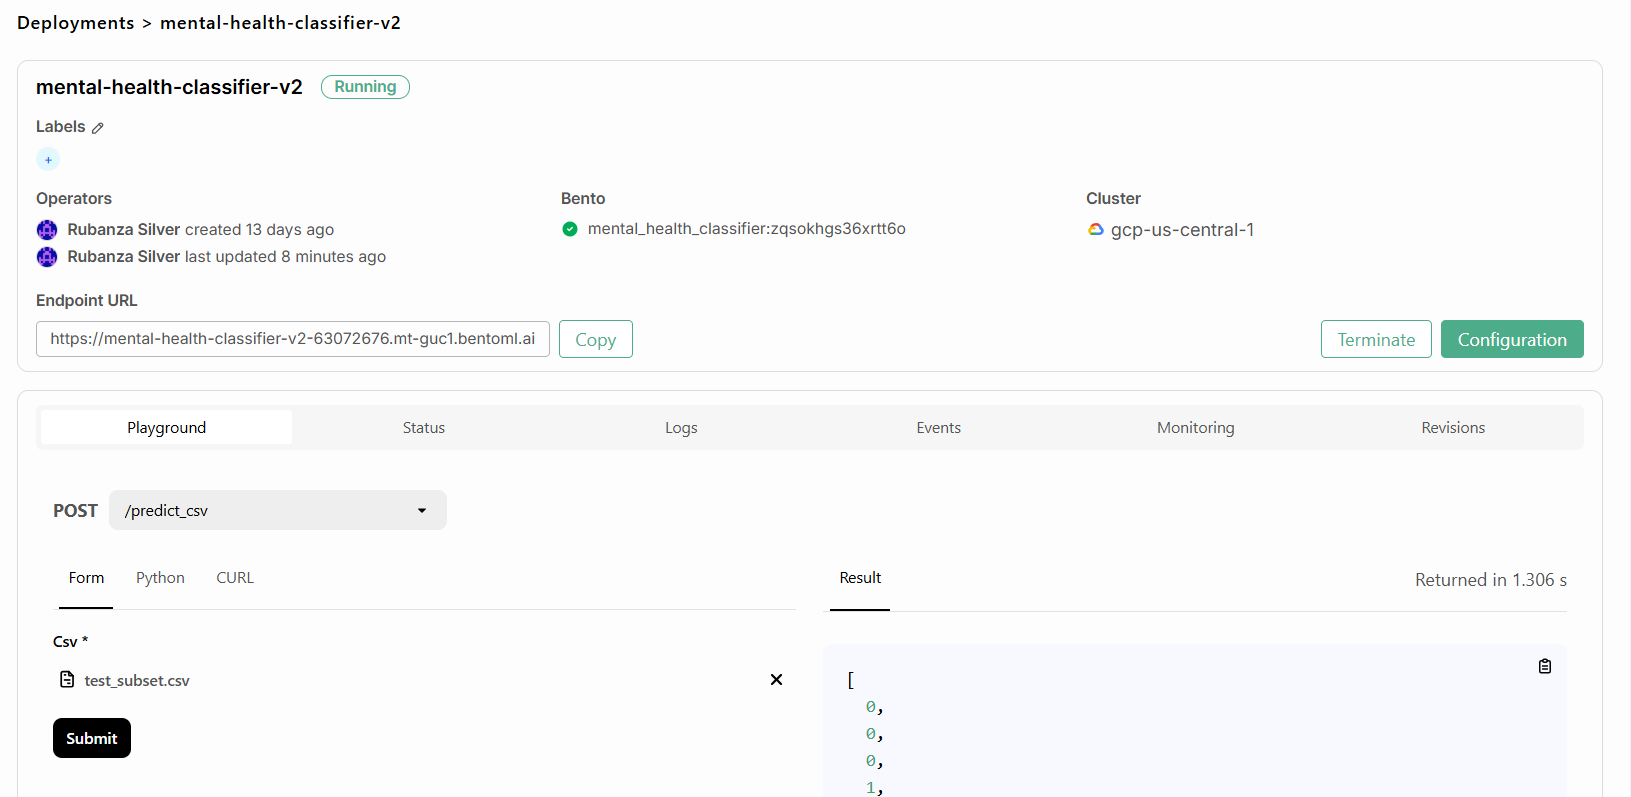

You can now call this endpoint and interact with it in various ways.

## Deploy to any other cloud provider

To do this, first, we build our bento by running **bentoml build** via our terminal. After building, a unique tag is assigned to each bento. We can view our bentos by running **bentoml list** via the terminal.

You should only use the above bentoml build if you want to build a bento without deploying it to the bentocloud. For bentocloud deployment I would use bentoml deploy . as shown above.'

In [ ]:
!bentoml build

In [26]:
!bentoml list

 Tag                                 Size       Model Size  Creation Time       
 sticker_sales_regressor:vyptbcgyt…  20.28 MiB  476.22 KiB  2025-01-22 11:34:28 
 mental_health_classifier:zqsokhgs…  26.80 MiB  421.24 KiB  2025-01-15 04:26:52 
 mental_health_classifier:mb5cnows…  26.80 MiB  421.24 KiB  2025-01-15 04:23:54 
 mental_health_classifier:wuirrnwm…  26.79 MiB  421.24 KiB  2025-01-07 13:39:48 


### Containerize

To have a bento i can use anywhere i Containerize my Bento with docker by running **bentoml containerize mental_health_classifier:latest
**

In [ ]:
!bentoml containerize mental_health_classifier:latest
#run the below command via the terminal in your project directory
#bentoml deploy . -n mental_health_classifier

To view the created docker images, we run the below

In [28]:
! docker images

REPOSITORY                              TAG                IMAGE ID       CREATED       SIZE
sticker_sales_regressor                 vyptbcgytobgu5jh   c37b3f85616a   5 days ago    17.2GB
mental_health_classifier                wuirrnwm4okx3l7b   af4be94073a4   2 weeks ago   16.8GB
silvarubanza/mental_health_classifier   latest             af4be94073a4   2 weeks ago   16.8GB


With a docker image, we can run our model in any docker compatible enviroment.

## Building a UI.

To interact with our model, we build a user interface that can take in the required output and return the predictions as output. To do this i shall be using [Gradio](https://www.gradio.app/guides/quickstart) which describes it self as a 
> an open-source Python package that allows you to quickly build a demo or web application for your machine learning model, API, or any 
> arbitrary Python function. 


In [ ]:
!mkdir gradio_ui_a
!touch app_c.py

First, i create a folder *gradio_ui* within my project directory. Within this i create an app.py file which i pass by UI code below.

```
import gradio as gr
import requests
import pandas as pd
import tempfile
import os

def predict_depression(name, gender, city, occupation_type, profession, sleep_duration, 
                      dietary_habits, degree, suicidal_thoughts, family_history,
                      age, academic_pressure, work_pressure, cgpa, 
                      study_satisfaction, job_satisfaction, work_hours, financial_stress):
    
    # Create the input data structure
    data = {
        "data": [{
            "Name": name,
            "Gender": gender,
            "City": city,
            "Working Professional or Student": occupation_type,
            "Profession": profession,
            "Sleep Duration": sleep_duration,
            "Dietary Habits": dietary_habits,
            "Degree": degree,
            "Have you ever had suicidal thoughts ?": suicidal_thoughts,
            "Family History of Mental Illness": family_history,
            "Age": age,
            "Academic Pressure": academic_pressure,
            "Work Pressure": work_pressure,
            "CGPA": cgpa,
            "Study Satisfaction": study_satisfaction,
            "Job Satisfaction": job_satisfaction,
            "Work/Study Hours": work_hours,
            "Financial Stress": financial_stress
        }]
    }
    
    # Make prediction request to BentoML service
    try:
        response = requests.post(
            "http://localhost:3000/predict",
            json=data,
            headers={"content-type": "application/json"}
        )
        
        if response.status_code == 200:
            prediction = response.json()
            return "Depression Risk: Yes" if prediction[0] == 1 else "Depression Risk: No"
        else:
            return f"Error: {response.status_code} - {response.text}"
    except requests.exceptions.RequestException as e:
        return f"Error connecting to service: {str(e)}"

def predict_csv_file(file_obj):
    try:
        # Check if file was uploaded
        if file_obj is None:
            return None, "Please upload a CSV file"
            
        # Read the uploaded CSV file directly using pandas
        df = pd.read_csv(file_obj.name)
        
        # Create multipart form-data
        files = {
            'csv': ('input.csv', open(file_obj.name, 'rb'), 'text/csv')
        }
        
        # Make prediction request to BentoML service
        response = requests.post(
            "http://localhost:3000/predict_csv",
            files=files
        )
        
        if response.status_code == 200:
            predictions = response.json()
            
            # Create a DataFrame with original data and predictions
            df['Depression Risk'] = ['Yes' if pred == 1 else 'No' for pred in predictions]
            
            # Save results to a CSV file
            results_path = "predictions_results.csv"
            df.to_csv(results_path, index=False)
            
            # Create a formatted prediction list
            prediction_list = []
            for index, row in df.iterrows():
                prediction_text = f"Record {index + 1}: {row['Name']} - Depression Risk: {row['Depression Risk']}"
                prediction_list.append(prediction_text)
            
            # Join predictions into a single string with line breaks
            predictions_display = "\n".join(prediction_list)
            
            return results_path, predictions_display
        else:
            return None, f"Error: {response.status_code} - {response.text}"
            
    except Exception as e:
        return None, f"Error processing file: {str(e)}"

# Create the individual prediction interface
individual_inputs = [
    gr.Textbox(label="Name"),
    gr.Dropdown(
        choices=["Male", "Female", "Other"],
        label="Gender"
    ),
    gr.Textbox(label="City"),
    gr.Dropdown(
        choices=["Working Professional", "Student"],
        label="Occupation Type"
    ),
    gr.Textbox(label="Profession"),
    gr.Dropdown(
        choices=["Less than 6 hours", "6-8 hours", "More than 8 hours"],
        label="Sleep Duration"
    ),
    gr.Dropdown(
        choices=["Healthy", "Moderate", "Unhealthy"],
        label="Dietary Habits"
    ),
    gr.Textbox(label="Degree"),
    gr.Radio(
        choices=["Yes", "No"],
        label="Have you ever had suicidal thoughts?"
    ),
    gr.Radio(
        choices=["Yes", "No"],
        label="Family History of Mental Illness"
    ),
    gr.Number(label="Age"),
    gr.Slider(minimum=0, maximum=10, step=1, label="Academic Pressure"),
    gr.Slider(minimum=0, maximum=10, step=1, label="Work Pressure"),
    gr.Number(label="CGPA", minimum=0, maximum=10),
    gr.Slider(minimum=0, maximum=10, step=1, label="Study Satisfaction"),
    gr.Slider(minimum=0, maximum=10, step=1, label="Job Satisfaction"),
    gr.Number(label="Work/Study Hours"),
    gr.Slider(minimum=0, maximum=10, step=1, label="Financial Stress")
]

individual_output = gr.Textbox(label="Prediction Result")

# Create the batch processing interface
batch_inputs = [
    gr.File(
        label="Upload CSV File",
        file_types=[".csv"]
    )
]

batch_outputs = [
    gr.File(label="Download Complete Predictions CSV"),
    gr.Textbox(label="Predictions", lines=10)
]

# Create the combined interface with tabs
demo = gr.Blocks(title="Mental Health Depression Risk Prediction System")

with demo:
    gr.Markdown("# Mental Health Depression Risk Prediction System")
    
    with gr.Tabs():
        with gr.TabItem("Individual Prediction"):
            gr.Markdown("Enter individual information to predict depression risk.")
            with gr.Column():
                individual_interface = gr.Interface(
                    fn=predict_depression,
                    inputs=individual_inputs,
                    outputs=individual_output,
                    title=None
                )
        
        with gr.TabItem("Batch Processing"):
            gr.Markdown("""Upload a CSV file containing multiple records for batch prediction. 
            The CSV should contain the following columns:
            Name, Gender, City, Working Professional or Student, Profession, Sleep Duration, 
            Dietary Habits, Degree, Have you ever had suicidal thoughts?, Family History of Mental Illness,
            Age, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, 
            Work/Study Hours, Financial Stress""")
            with gr.Column():
                batch_interface = gr.Interface(
                    fn=predict_csv_file,
                    inputs=batch_inputs,
                    outputs=batch_outputs,
                    title=None
                )

if __name__ == "__main__":
    demo.launch(server_name="0.0.0.0", server_port=7860)

```

The above code results in the below UI, for single and batch predictions.

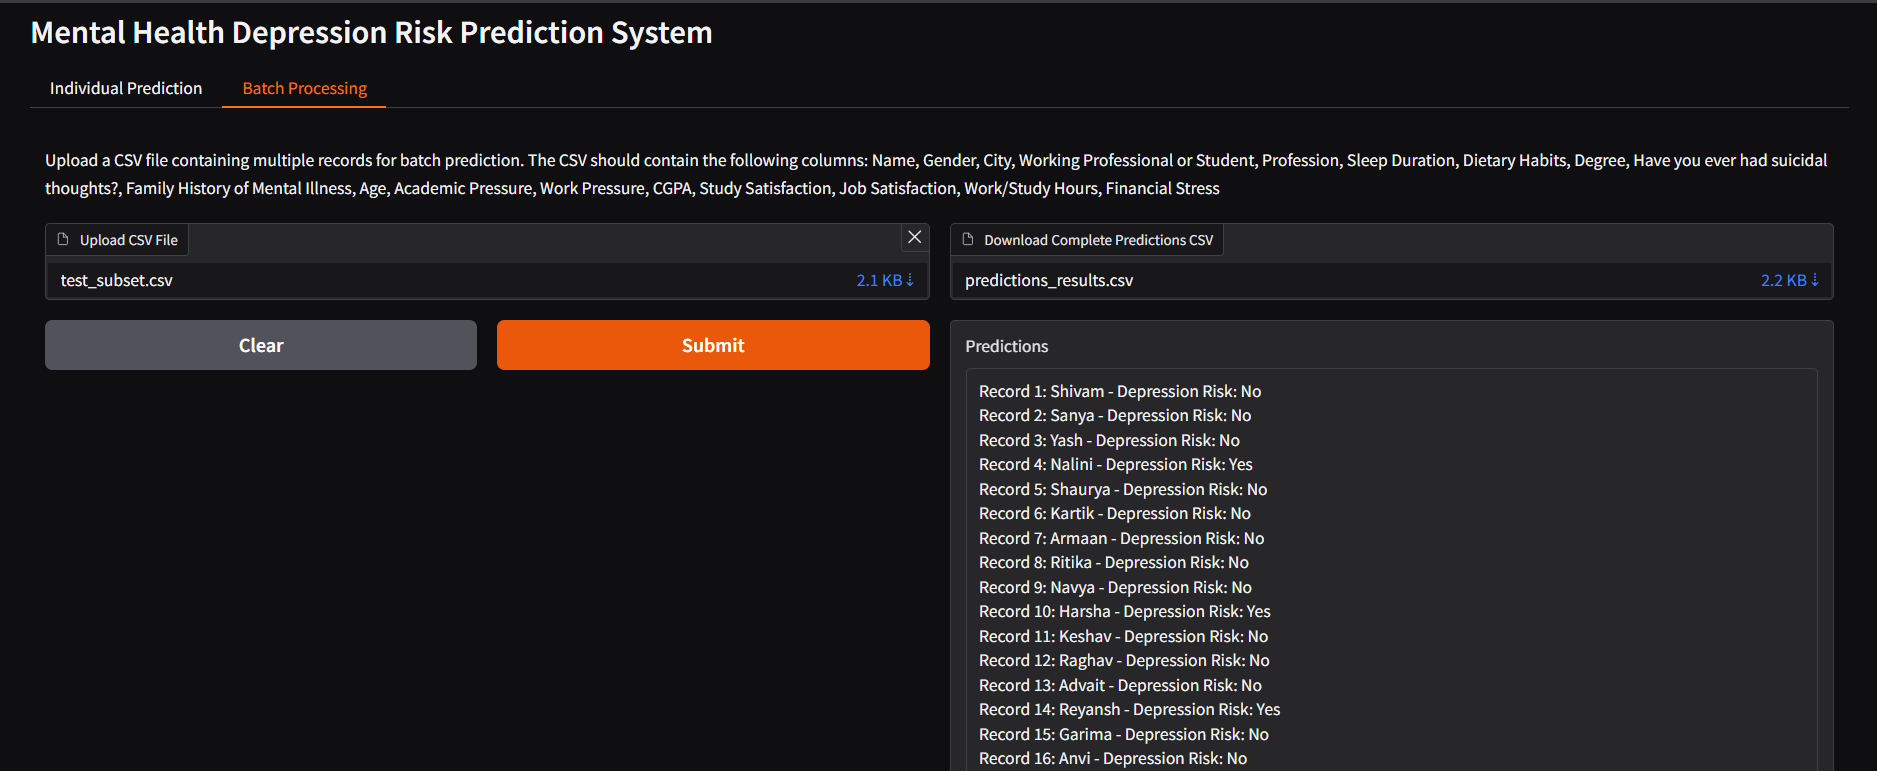

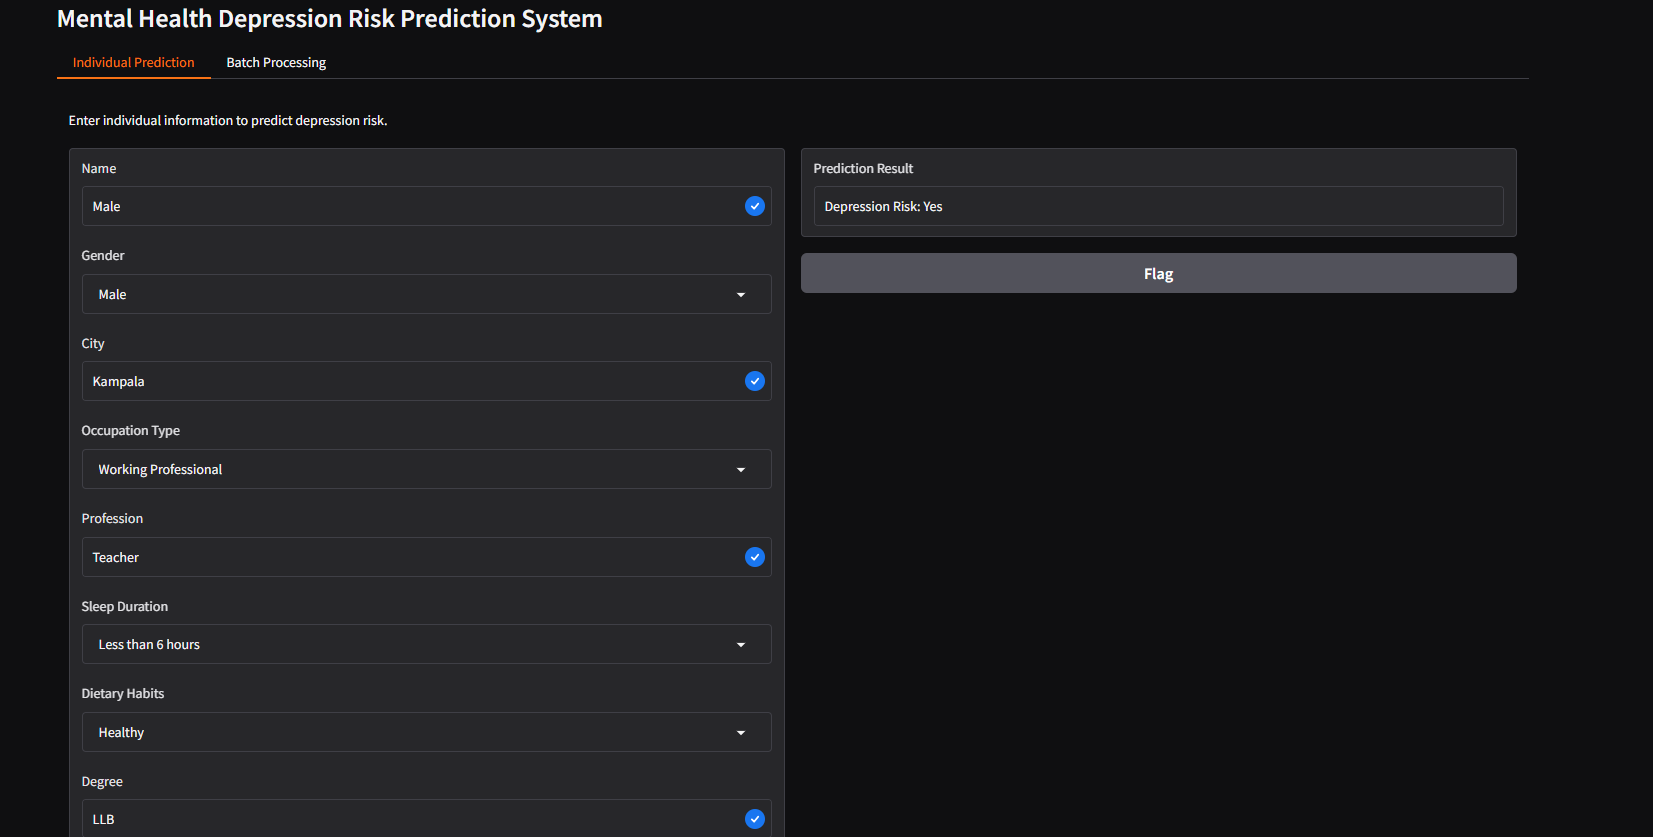

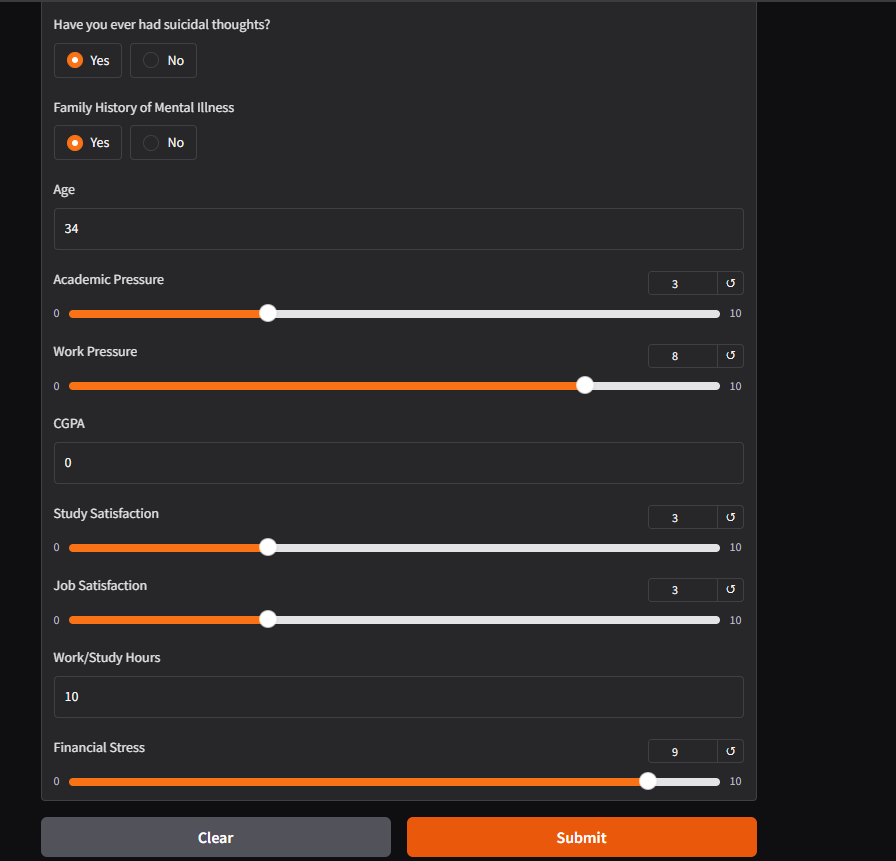

